In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


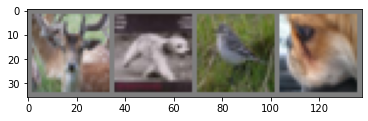

 deer   dog  bird   dog


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
params = list(net.parameters())
k = 0
for i in params:
    l = 1
    print("Framework of this layer: " + str(list(i.size())))
    for j in i.size():
        l *= j
    print("# Parameters in this layer: " + str(l))
    k = k + l
print("# Parameters: " + str(k))

Framework of this layer: [6, 3, 5, 5]
# Parameters in this layer: 450
Framework of this layer: [6]
# Parameters in this layer: 6
Framework of this layer: [16, 6, 5, 5]
# Parameters in this layer: 2400
Framework of this layer: [16]
# Parameters in this layer: 16
Framework of this layer: [120, 400]
# Parameters in this layer: 48000
Framework of this layer: [120]
# Parameters in this layer: 120
Framework of this layer: [84, 120]
# Parameters in this layer: 10080
Framework of this layer: [84]
# Parameters in this layer: 84
Framework of this layer: [10, 84]
# Parameters in this layer: 840
Framework of this layer: [10]
# Parameters in this layer: 10
# Parameters: 62006


1. From the cell above we know the number of parameter is 62006. Here is how to get this number:

conv1 : 6 * 3 * 5 * 5 + 6 = 450 + 6 = 456

conv2 : 16 * 6 * 5 * 5 + 16 = 2400 + 16 = 2416

fc1 : 120 * 400 + 120 = 48000 + 120 = 48120

fc2 : 84 * 120 + 84 = 10080 + 84 = 10164

fc3 : 10 * 84 + 10 = 840 + 10 = 850

2. The input size of Net is torch.Size([4, 3, 32, 32]) and the output size is torch.Size([4, 10]). I choose to use a similar MLP framework as HW3, with input dimension 3 * 32 * 32 and output dimension 10.

In [7]:
class MLP(nn.Module):
    def __init__(self):

        super(MLP, self).__init__()

        self.inp = nn.Linear(3*32*32, 128)
        self.hid = nn.Linear(128, 64)
        self.out = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):

        h_1 = F.relu(self.inp(x))
        h_2 = F.relu(self.hid(h_1))
        out = self.out(h_2)
        out = self.relu(out)
        return out


mlpnet = MLP().to(device)

In [8]:
params = list(mlpnet.parameters())
k = 0
for i in params:
    l = 1
    print("Framework of this layer: " + str(list(i.size())))
    for j in i.size():
        l *= j
    print("# Parameters in this layer: " + str(l))
    k = k + l
print("# Parameters: " + str(k))

Framework of this layer: [128, 3072]
# Parameters in this layer: 393216
Framework of this layer: [128]
# Parameters in this layer: 128
Framework of this layer: [64, 128]
# Parameters in this layer: 8192
Framework of this layer: [64]
# Parameters in this layer: 64
Framework of this layer: [10, 64]
# Parameters in this layer: 640
Framework of this layer: [10]
# Parameters in this layer: 10
# Parameters: 402250


In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(mlpnet.parameters(), lr=learning_rate)

In [10]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data[0].to(device)
        labels = data[1].to(device)
        inputs = inputs.reshape(batch_size,-1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = mlpnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.121
[1,  4000] loss: 1.976
[1,  6000] loss: 1.925
[1,  8000] loss: 1.869
[1, 10000] loss: 1.864
[1, 12000] loss: 1.816
[2,  2000] loss: 1.661
[2,  4000] loss: 1.659
[2,  6000] loss: 1.645
[2,  8000] loss: 1.633
[2, 10000] loss: 1.599
[2, 12000] loss: 1.598
Finished Training


In [11]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.reshape(batch_size,-1).to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network 
        outputs = mlpnet(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 43 %


3. Here I defined my own CNN. I first tried a sequential CNN with more layers and a larger batch size. Then for the second CNN I increased the amount of layers, added convolutional blocks that have a kernel size of 3.

In [12]:
# Code reference: https://shonit2096.medium.com/cnn-on-cifar10-data-set-using-pytorch-34be87e09844

class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flattening
        x = x.view(-1, 64 * 4 * 4)
        # fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

cnnnet = CNN1().to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnnnet.parameters(), lr=0.001, momentum=0.9)

In [14]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data[0].to(device)
        labels = data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnnnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 2.286
[1,  4000] loss: 2.105
[1,  6000] loss: 1.933
[1,  8000] loss: 1.776
[1, 10000] loss: 1.693
[1, 12000] loss: 1.612
[2,  2000] loss: 1.535
[2,  4000] loss: 1.510
[2,  6000] loss: 1.463
[2,  8000] loss: 1.407
[2, 10000] loss: 1.377
[2, 12000] loss: 1.345
[3,  2000] loss: 1.273
[3,  4000] loss: 1.253
[3,  6000] loss: 1.235
[3,  8000] loss: 1.213
[3, 10000] loss: 1.216
[3, 12000] loss: 1.193
[4,  2000] loss: 1.110
[4,  4000] loss: 1.109
[4,  6000] loss: 1.108
[4,  8000] loss: 1.082
[4, 10000] loss: 1.097
[4, 12000] loss: 1.090
[5,  2000] loss: 1.010
[5,  4000] loss: 1.026
[5,  6000] loss: 0.995
[5,  8000] loss: 0.996
[5, 10000] loss: 0.979
[5, 12000] loss: 1.006
Finished Training


In [15]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network 
        outputs = cnnnet(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %


In [16]:
class CNN2(nn.Module):

    def __init__(self):
        
        super(CNN2, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):

        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)

        return x

cnnnet = CNN2().to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnnnet.parameters(), lr=0.001, momentum=0.9)

In [18]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data[0].to(device)
        labels = data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnnnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.854
[1,  4000] loss: 1.504
[1,  6000] loss: 1.306
[1,  8000] loss: 1.158
[1, 10000] loss: 1.032
[1, 12000] loss: 0.978
[2,  2000] loss: 0.859
[2,  4000] loss: 0.820
[2,  6000] loss: 0.779
[2,  8000] loss: 0.765
[2, 10000] loss: 0.753
[2, 12000] loss: 0.717
[3,  2000] loss: 0.579
[3,  4000] loss: 0.619
[3,  6000] loss: 0.603
[3,  8000] loss: 0.567
[3, 10000] loss: 0.579
[3, 12000] loss: 0.568
[4,  2000] loss: 0.441
[4,  4000] loss: 0.463
[4,  6000] loss: 0.447
[4,  8000] loss: 0.475
[4, 10000] loss: 0.454
[4, 12000] loss: 0.454
[5,  2000] loss: 0.326
[5,  4000] loss: 0.336
[5,  6000] loss: 0.350
[5,  8000] loss: 0.360
[5, 10000] loss: 0.358
[5, 12000] loss: 0.376
Finished Training


In [19]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network 
        outputs = cnnnet(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 80 %


4. Results and conclusion

(1) The original network gives better results (53% accuracy) than MLP (43% accuracy) which means CNN is necessary when we dealing with image data. 
 
(2) I used a similar MLP framework as in HW3, which has 3 layers, but got a much worse result (in HW3 I got a 0.13 loss at last but here I can only get 1.598). So I think at least from these two datasets we can claim that MLP works better on a small dataset and CNN is more suitable on large datasets.
 
(3) For my own CNN, I tried two CNNs. I ran 5 epochs for both of them while the original CNN only ran 2 epochs. The first CNN is a sequential CNN with more layers and a larger batch size compared with the original model. Then for the second CNN I increased the amount of layers, added convolutional blocks that have a kernel size of 3.
 
The first CNN gave a 63% accuracy and a 0.979 loss, while the second one gave a 80% accuracy and a 0.326 loss. In this way, we can say that adding layers and convolutional blocks to CNN can increase the model performance.

Meanwhile, both of my CNNs converge at epoch 5, which means train more epochs can also improve the model accuracy.
